<a href="https://colab.research.google.com/github/jmamath/learning-approximate-invariance-requires-far-fewer-data/blob/master/Sample_size_and_augmentation_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More efficient invariant learning

In [ ]:
# !pip install Augmentor
!pip install imgaug

## 1. Imports packages and load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

import torch
from torch.distributions import Normal
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from tqdm import trange
 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import imgaug
from keras.datasets import mnist
from imgaug import augmenters as iaa
from keras.utils import np_utils
torch.set_default_tensor_type('torch.cuda.FloatTensor')

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
cuda:0


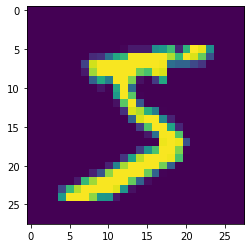

In [ ]:
# Download the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Categorizing our data: 
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# normalizing the data to help with the training
x_train = (x_train / 255).astype(np.float32)
x_test = (x_train / 255).astype(np.float32)

# Show an example
plt.imshow(x_train[0])

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

# Be sure that we are using the GPU
print(device)

## 2. Classes

In [ ]:
#@title Dataset class
class MyData(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels, return_perturb=False, sample_size=None, augmentation=None, training=False):
        'Initialization'
        self.labels = labels
        self.data = data      
        self.return_perturb = return_perturb
        self.augmentation = augmentation
        self.sample_size = sample_size      
        self.training = training

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]      
        h, w = X.shape
        # Load data and get label
        y = self.labels[index]
        if self.return_perturb==False:          
          return X,y 
        elif self.sample_size > 1:          
          X_repeated = np.tile(X, [self.sample_size, 1, 1]) # Because we want X.shape = (sample_size, 28,28)
          y_repeated = np.tile(y, [self.sample_size, 1])  # Because we want y.shape = (sample_size, 10)
          X_aug = self.augmentation(images=X_repeated)  
          if self.training:
            # import pdb; pdb.set_trace()
            X_repeated = X_repeated.reshape(self.sample_size,-1)        
            X_aug = X_aug.reshape(self.sample_size,-1)
          return X_repeated, X_aug, y_repeated
        else:
          X_aug = self.augmentation(images=X)
          X_aug = X_aug.reshape(-1)
          X = X.reshape(-1)
          return X, X_aug, y


In [ ]:
#@title Early Stopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):

        score = -val_loss
        # 1st iteration
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # if not os.path.exists(path):
        #     os.makedirs(path)
        # torch.save(model.state_dict(), path+'/checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
#@title Invariant Prior class
############### 2. CREATE THE MODEL ############### 
class GaussianPrior(nn.Module):
    def __init__(self, shape):
        super(GaussianPrior, self).__init__()
        self.shape = shape        
        self.mu = nn.Parameter(torch.rand(shape))
        self.log_var = nn.Parameter(torch.rand(shape))
        
    def forward(self, num_samples=1):
        if not isinstance(num_samples, tuple):
            num_samples = (num_samples,)
        eps_shape = num_samples + self.shape
        eps = torch.randn(eps_shape) # ~ N(0,I)
        return self.mu + torch.exp(self.log_var) * eps
    
    def entropy(self):
        distribution = Normal(loc=self.mu, scale=self.log_var.exp())
        return distribution.entropy().mean()
                  
    
class ApproximateInvariance(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, sample_size, prior=GaussianPrior):
        super(ApproximateInvariance, self).__init__()
        self.prior = prior    
        self.sample_size = sample_size
        self.input_dim = input_dim
        self.output_dim = output_dim                  
        self.weight_1 = prior((hidden_dim, input_dim))
        self.bias_1 = prior((hidden_dim,))   
        self.weight_2 = prior((output_dim, hidden_dim)) 
        self.bias_2 = prior((output_dim,)) 
        
    def batch_forward(self, x, x_aug):
        # We remove the num_sample dimension if it is equal to one.
        w1 = self.weight_1().squeeze(0)
        b1 = self.bias_1()  
        w2 = self.weight_2().squeeze(0)
        b2 = self.bias_2()              
        
        x = F.linear(x, w1, b1)
        x = F.relu(x)
        x = F.linear(x, w2, b2) 
        x = F.softmax(x) + 1e-8              

        x_aug = F.linear(x_aug, w1, b1)           
        x_aug = F.relu(x_aug)
        x_aug = F.linear(x_aug, w2, b2) 
        x_aug = F.softmax(x_aug) + 1e-8        
        return x, x_aug

    def forward(self, x, x_aug):
        """
        We need to compute the output of the neural network for the input x
        and the augmented input x_aug with the same weights. And we need 
        to sample a new set of weights for each augmentation, hence the loop
        Input:
          x: torch Tensor. shape = (batch_size, num_sample, input_dim)
          x_aug: has the same attribute as x. but here for each num_sample there is a different augmentation
          while for x the tensor is repeated to leverage broadcasting.
        """
        if self.sample_size > 1:
          batch_size, num_samples, _ = x.shape
          results = torch.zeros(batch_size, num_samples, self.output_dim)
          results_aug = torch.zeros_like(results)
          for i in range(num_samples):
            results[:,i], results_aug[:,i] = self.batch_forward(x[:,i], x_aug[:,i])          
        else:
          results, results_aug = self.batch_forward(x, x_aug)
        return results, results_aug

    def entropy(self):
        """
        Each weight computes its own entropy
        """
        entropy_w1 = self.weight_1.entropy()
        entropy_b1 = self.bias_1.entropy()
        entropy_w2 = self.weight_2.entropy()
        entropy_b2 = self.bias_2.entropy()
        return entropy_w1 + entropy_b1 + entropy_w2 + entropy_b2

    def sample(self, num_samples=5):
        w1_samples = self.weight_1(num_samples=num_samples).view((num_samples, -1))
        b1_samples = self.bias_1(num_samples=num_samples).view((num_samples, -1))
        w2_samples = self.weight_2(num_samples=num_samples).view((num_samples, -1))
        b2_samples = self.bias_2(num_samples=num_samples).view((num_samples, -1))

        gen_weights = torch.cat([w1_samples, b1_samples, w2_samples, b2_samples], 1)

        return gen_weights

def kl_div_output(pred1, pred2, sample_size):
    """
    This function computes the KL divergence between the output of
    the standard neural network and and neural network with augmented data
    Input:
        pred1. Float tensor. K-class softmax prediction of network 1
        pred2. Float tensor. K-class softmax prediction of network 2
    Output:
        kl_div. Float. The KL divergence between the two
    """
    if sample_size > 1:
      batch_size, num_sample, output_dim = pred1.shape
      log_ratio = torch.log(pred1/pred2)
      kl_div = torch.mean(pred1 * log_ratio, axis=[0,1]) # Average over num_sample and batches      
      return kl_div.sum()
    else:
      log_ratio = torch.log(pred1/pred2)
      kl_div = torch.mean(pred1 * log_ratio, axis=0) # Average over batches
      return kl_div.sum()
  

## 3. Experiment

In [ ]:
# Experiment parameters
batch_size = [256, 512, 1024]
augment_size = [16, 32, 64]

rotation = iaa.Affine(rotate=(-20, 20), name="rotation")
noise = iaa.AddElementwise((0, 1), name="noise")
rotation_noise = iaa.Sequential([iaa.Affine(rotate=(-180, 180)),
                          iaa.AddElementwise((0, 1))], name="rotation_noise")

augmentation = [rotation, noise, rotation_noise]

_, width, height = x_train.shape
epochs = 2500
evaluations = 10

In [ ]:
for augment in augmentation:
  for batch in batch_size:
    for expand in augment_size:
      PreTrainingData = MyData(x_train, y_train, return_perturb=True, sample_size=expand, augmentation=augment, training=True)
      pretrainingloader = DataLoader(PreTrainingData, batch_size=batch, shuffle=True)
      model_attributes = "{}_{}_{}".format(augment.name, batch, expand)    
      print("Model "+ model_attributes)
      print("Get a batch of data...")
      for x,x_aug,y in pretrainingloader:
        batch_x = x
        batch_y = y
        batch_x_aug = x_aug
        break
      print("-----------------------------------------------------------------")
      print("Instantiate model...")
      model = ApproximateInvariance(input_dim=width * height, hidden_dim=512, output_dim=10, sample_size=expand)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      # initialize the early_stopping object
      early_stopping = EarlyStopping(patience=500, verbose=True)   
      print("Start training...")
      with trange(epochs) as pbar:
        for i in pbar:      
          optimizer.zero_grad()
          preds_x, preds_x_aug = model(batch_x, batch_x_aug)
          entropy = model.entropy()
          kl = kl_div_output(preds_x, preds_x_aug, expand) 
          loss = kl - (i/epochs)*entropy              
          loss.backward()      
          optimizer.step()              
          # early_stopping needs the validation loss to check if it has decresed, 
          # and if it has, it will make a checkpoint of the current model
          early_stopping(kl, model, "pre_train")          
          if early_stopping.early_stop:
              print("Early stopping")
              break      
          pbar.set_postfix(kl=kl.cpu().detach().numpy(),  entropy=entropy.cpu().detach().numpy())
        print("-----------------------------------------------------------------")          
        print("Evaluate model...")
        ## Transfer the learnt weight to a new model
        num_sample = 1
        TrainingData = MyData(x_train, y_train, return_perturb=True, sample_size=num_sample, augmentation=augment, training=True)
        trainingloader = DataLoader(TrainingData, batch_size=batch, shuffle=True)
        approx_model = ApproximateInvariance(input_dim=width * height, hidden_dim=512, output_dim=10, sample_size=num_sample)
        approx_model.load_state_dict(model.state_dict())        
        kl_evaluations = []      
        with trange(evaluations) as pbar:
          for i in pbar:
            kl_batch = []
            loss_batch = []
            for x, x_aug, _ in trainingloader:        
              preds_x, preds_x_aug = approx_model(x, x_aug)
              entropy = approx_model.entropy()
              kl = kl_div_output(preds_x, preds_x_aug, num_sample)         
              loss = entropy - kl  # Because we minimize the negative of the true objective

              loss_batch.append(loss)        
              kl_batch.append(kl)                
              pbar.set_postfix(loss=loss.cpu().detach().numpy(), kl=kl.cpu().detach().numpy(),  entropy=entropy.cpu().detach().numpy())
            kl_evaluations.append(torch.tensor(kl_batch).cpu().numpy()) 
        np.save(model_attributes, np.array(kl_evaluations))  
        print("-----------------------------------------------------------------")
          
        


Model rotation_1024_16
Get a batch of data...


  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 1/2500 [00:00<07:40,  5.43it/s, entropy=7.695473, kl=5.8615704]

-----------------------------------------------------------------
Instantiate model...
Start training...
Validation loss decreased (inf --> 5.861570).  Saving model ...


  0%|          | 7/2500 [00:00<04:31,  9.20it/s, entropy=7.6967087, kl=6.404802]

Validation loss decreased (5.861570 --> 4.876617).  Saving model ...
Validation loss decreased (4.876617 --> 4.650480).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (4.650480 --> 4.017694).  Saving model ...
EarlyStopping counter: 1 out of 500


  1%|          | 14/2500 [00:00<02:55, 14.20it/s, entropy=7.6982346, kl=6.859503]

EarlyStopping counter: 2 out of 500
Validation loss decreased (4.017694 --> 3.792221).  Saving model ...
Validation loss decreased (3.792221 --> 3.237658).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


  1%|          | 20/2500 [00:00<02:11, 18.83it/s, entropy=7.7006564, kl=6.179783]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


  1%|          | 23/2500 [00:01<01:58, 20.96it/s, entropy=7.7035637, kl=2.22765]  

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
Validation loss decreased (3.237658 --> 2.227650).  Saving model ...
EarlyStopping counter: 1 out of 500


  1%|▏         | 33/2500 [00:01<01:39, 24.76it/s, entropy=7.708031, kl=3.9951246]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


  2%|▏         | 39/2500 [00:01<01:31, 26.79it/s, entropy=7.7126126, kl=7.1654987]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500


  2%|▏         | 46/2500 [00:01<01:26, 28.38it/s, entropy=7.718837, kl=5.215367]

EarlyStopping counter: 14 out of 500
Validation loss decreased (2.227650 --> 2.211551).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


  2%|▏         | 52/2500 [00:01<01:25, 28.51it/s, entropy=7.7245417, kl=6.498928]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500


  2%|▏         | 58/2500 [00:02<01:24, 28.94it/s, entropy=7.7307763, kl=4.524013]

EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500


  3%|▎         | 64/2500 [00:02<01:26, 28.18it/s, entropy=7.7377176, kl=4.922389]

EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500


  3%|▎         | 71/2500 [00:02<01:23, 29.26it/s, entropy=7.7461147, kl=3.9361668]

EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500


  3%|▎         | 77/2500 [00:02<01:22, 29.50it/s, entropy=7.7538533, kl=4.1877446]

EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500
EarlyStopping counter: 36 out of 500


  3%|▎         | 83/2500 [00:03<01:22, 29.13it/s, entropy=7.7613115, kl=2.828849]

EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500


  4%|▎         | 89/2500 [00:03<01:23, 28.90it/s, entropy=7.768871, kl=5.4702134]

EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500


  4%|▍         | 96/2500 [00:03<01:22, 29.28it/s, entropy=7.778654, kl=5.0370827]

EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500


  4%|▍         | 103/2500 [00:03<01:20, 29.77it/s, entropy=7.7886124, kl=5.6911917]

EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500
EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500


  4%|▍         | 109/2500 [00:03<01:22, 29.13it/s, entropy=7.7973027, kl=5.643916]

EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500
EarlyStopping counter: 66 out of 500
EarlyStopping counter: 67 out of 500
EarlyStopping counter: 68 out of 500


  5%|▍         | 115/2500 [00:04<01:22, 28.77it/s, entropy=7.8061733, kl=3.930839]

EarlyStopping counter: 69 out of 500
EarlyStopping counter: 70 out of 500
EarlyStopping counter: 71 out of 500
EarlyStopping counter: 72 out of 500
EarlyStopping counter: 73 out of 500
EarlyStopping counter: 74 out of 500


  5%|▍         | 121/2500 [00:04<01:22, 28.73it/s, entropy=7.8154125, kl=3.8718214]

EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500
EarlyStopping counter: 78 out of 500
EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500


  5%|▌         | 128/2500 [00:04<01:20, 29.34it/s, entropy=7.826254, kl=2.5979128]

EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500
EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500


  5%|▌         | 134/2500 [00:04<01:23, 28.37it/s, entropy=7.835628, kl=6.4642963]

EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500
EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500
EarlyStopping counter: 93 out of 500


  5%|▌         | 137/2500 [00:04<01:23, 28.15it/s, entropy=7.845145, kl=4.6889997] 

EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500
EarlyStopping counter: 96 out of 500
EarlyStopping counter: 97 out of 500
EarlyStopping counter: 98 out of 500
EarlyStopping counter: 99 out of 500


  6%|▌         | 144/2500 [00:05<01:23, 28.21it/s, entropy=7.8546534, kl=4.7433457]

EarlyStopping counter: 100 out of 500
EarlyStopping counter: 101 out of 500
EarlyStopping counter: 102 out of 500
EarlyStopping counter: 103 out of 500
EarlyStopping counter: 104 out of 500
EarlyStopping counter: 105 out of 500


  6%|▌         | 150/2500 [00:05<01:22, 28.51it/s, entropy=7.8642683, kl=4.9044933]

EarlyStopping counter: 106 out of 500
EarlyStopping counter: 107 out of 500
EarlyStopping counter: 108 out of 500
EarlyStopping counter: 109 out of 500
EarlyStopping counter: 110 out of 500
EarlyStopping counter: 111 out of 500


  6%|▌         | 156/2500 [00:05<01:20, 28.95it/s, entropy=7.8738885, kl=6.190318]

EarlyStopping counter: 112 out of 500
EarlyStopping counter: 113 out of 500
EarlyStopping counter: 114 out of 500
EarlyStopping counter: 115 out of 500
EarlyStopping counter: 116 out of 500
EarlyStopping counter: 117 out of 500


  7%|▋         | 163/2500 [00:05<01:18, 29.58it/s, entropy=7.883604, kl=2.3012118] 

EarlyStopping counter: 118 out of 500
EarlyStopping counter: 119 out of 500
EarlyStopping counter: 120 out of 500
EarlyStopping counter: 121 out of 500
EarlyStopping counter: 122 out of 500
EarlyStopping counter: 123 out of 500


  7%|▋         | 170/2500 [00:06<01:19, 29.18it/s, entropy=7.893463, kl=2.950903]

EarlyStopping counter: 124 out of 500
EarlyStopping counter: 125 out of 500
EarlyStopping counter: 126 out of 500
EarlyStopping counter: 127 out of 500
EarlyStopping counter: 128 out of 500
EarlyStopping counter: 129 out of 500


  7%|▋         | 176/2500 [00:06<01:21, 28.36it/s, entropy=7.90314, kl=5.1637034]

EarlyStopping counter: 130 out of 500
EarlyStopping counter: 131 out of 500
EarlyStopping counter: 132 out of 500
EarlyStopping counter: 133 out of 500
EarlyStopping counter: 134 out of 500
EarlyStopping counter: 135 out of 500


  7%|▋         | 182/2500 [00:06<01:21, 28.33it/s, entropy=7.912798, kl=3.7057128]

EarlyStopping counter: 136 out of 500
EarlyStopping counter: 137 out of 500
EarlyStopping counter: 138 out of 500
EarlyStopping counter: 139 out of 500
EarlyStopping counter: 140 out of 500
EarlyStopping counter: 141 out of 500


  7%|▋         | 185/2500 [00:06<01:20, 28.77it/s, entropy=7.922515, kl=3.9461837] 

EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500
EarlyStopping counter: 147 out of 500


  8%|▊         | 192/2500 [00:06<01:19, 29.13it/s, entropy=7.9324093, kl=4.2766476]

EarlyStopping counter: 148 out of 500
EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500


  8%|▊         | 198/2500 [00:07<01:20, 28.46it/s, entropy=7.9423323, kl=2.0595374]

EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStopping counter: 156 out of 500
EarlyStopping counter: 157 out of 500
EarlyStopping counter: 158 out of 500
Validation loss decreased (2.211551 --> 2.059537).  Saving model ...


  8%|▊         | 205/2500 [00:07<01:19, 28.87it/s, entropy=7.9521422, kl=3.962616]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500


  8%|▊         | 211/2500 [00:07<01:19, 28.74it/s, entropy=7.9620476, kl=4.206464]

EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500


  9%|▊         | 218/2500 [00:07<01:17, 29.41it/s, entropy=7.973733, kl=4.7250166] 

EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500


  9%|▉         | 225/2500 [00:07<01:19, 28.76it/s, entropy=7.983758, kl=3.787309]

EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500


  9%|▉         | 232/2500 [00:08<01:17, 29.36it/s, entropy=7.995557, kl=4.675529]

EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500


 10%|▉         | 238/2500 [00:08<01:18, 28.92it/s, entropy=8.005695, kl=5.610099]

EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500
EarlyStopping counter: 36 out of 500
EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500


 10%|▉         | 245/2500 [00:08<01:16, 29.58it/s, entropy=8.017582, kl=3.5631895]

EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500


 10%|█         | 252/2500 [00:08<01:16, 29.55it/s, entropy=8.029346, kl=2.4219627]

EarlyStopping counter: 46 out of 500
Validation loss decreased (2.059537 --> 1.604409).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 10%|█         | 258/2500 [00:09<01:16, 29.17it/s, entropy=8.039437, kl=3.4568]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500


 10%|█         | 261/2500 [00:09<01:16, 29.19it/s, entropy=8.04953, kl=2.598219] 

EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500


 11%|█         | 268/2500 [00:09<01:17, 28.66it/s, entropy=8.059706, kl=2.7350094]

EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500


 11%|█         | 274/2500 [00:09<01:19, 28.05it/s, entropy=8.069941, kl=1.3833543]

EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
Validation loss decreased (1.604409 --> 1.383354).  Saving model ...


 11%|█         | 281/2500 [00:09<01:16, 28.84it/s, entropy=8.0803795, kl=2.3796396]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500


 12%|█▏        | 288/2500 [00:10<01:16, 29.06it/s, entropy=8.090771, kl=3.559836]

EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500


 12%|█▏        | 295/2500 [00:10<01:15, 29.34it/s, entropy=8.102891, kl=2.7877724]

EarlyStopping counter: 13 out of 500
Validation loss decreased (1.383354 --> 1.207373).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 12%|█▏        | 301/2500 [00:10<01:16, 28.73it/s, entropy=8.113417, kl=3.2304475]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500


 12%|█▏        | 308/2500 [00:10<01:14, 29.36it/s, entropy=8.125621, kl=2.6980257]

EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500


 13%|█▎        | 314/2500 [00:11<01:15, 28.96it/s, entropy=8.136071, kl=1.4594707]

EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
Validation loss decreased (1.207373 --> 1.197348).  Saving model ...
EarlyStopping counter: 1 out of 500


 13%|█▎        | 320/2500 [00:11<01:15, 28.86it/s, entropy=8.146475, kl=1.221141]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 13%|█▎        | 326/2500 [00:11<01:15, 28.70it/s, entropy=8.156858, kl=2.3944511]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500


 13%|█▎        | 333/2500 [00:11<01:14, 29.21it/s, entropy=8.168863, kl=2.5640159]

EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
Validation loss decreased (1.197348 --> 0.980703).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 14%|█▎        | 339/2500 [00:11<01:15, 28.49it/s, entropy=8.179133, kl=2.5825655]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 14%|█▍        | 345/2500 [00:12<01:15, 28.73it/s, entropy=8.189436, kl=1.6843244]

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500


 14%|█▍        | 351/2500 [00:12<01:13, 29.07it/s, entropy=8.199797, kl=1.7398655]

EarlyStopping counter: 17 out of 500
Validation loss decreased (0.980703 --> 0.567743).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 14%|█▍        | 357/2500 [00:12<01:16, 28.15it/s, entropy=8.210253, kl=1.166379]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 15%|█▍        | 364/2500 [00:12<01:13, 29.16it/s, entropy=8.222378, kl=0.97302663]

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500


 15%|█▍        | 367/2500 [00:12<01:13, 28.94it/s, entropy=8.23288, kl=0.20072836]

EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
Validation loss decreased (0.567743 --> 0.200728).  Saving model ...
EarlyStopping counter: 1 out of 500


 15%|█▌        | 377/2500 [00:13<01:14, 28.47it/s, entropy=8.245226, kl=1.3629653]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 15%|█▌        | 383/2500 [00:13<01:14, 28.30it/s, entropy=8.255728, kl=1.3811846]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500


 16%|█▌        | 390/2500 [00:13<01:13, 28.54it/s, entropy=8.267896, kl=0.69038117]

EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500


 16%|█▌        | 397/2500 [00:13<01:11, 29.32it/s, entropy=8.280099, kl=1.4500091]

EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500


 16%|█▌        | 403/2500 [00:14<01:12, 28.93it/s, entropy=8.290571, kl=1.5641345]

EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500


 16%|█▋        | 409/2500 [00:14<01:11, 29.09it/s, entropy=8.301043, kl=1.1226137]

EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500
EarlyStopping counter: 36 out of 500
EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500


 17%|█▋        | 413/2500 [00:14<01:10, 29.45it/s, entropy=8.31151, kl=0.45507032]

EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500


 17%|█▋        | 420/2500 [00:14<01:11, 29.24it/s, entropy=8.321953, kl=0.66725904]

EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500


 17%|█▋        | 426/2500 [00:14<01:11, 29.00it/s, entropy=8.332444, kl=0.20741573]

EarlyStopping counter: 52 out of 500
Validation loss decreased (0.200728 --> 0.160968).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.160968 --> 0.156060).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 17%|█▋        | 432/2500 [00:15<01:12, 28.71it/s, entropy=8.342884, kl=0.8259716] 

EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500


 18%|█▊        | 439/2500 [00:15<01:10, 29.16it/s, entropy=8.353343, kl=1.3240478]

Validation loss decreased (0.156060 --> 0.125152).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.125152 --> 0.115581).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 18%|█▊        | 445/2500 [00:15<01:11, 28.76it/s, entropy=8.363797, kl=1.6295764]

EarlyStopping counter: 4 out of 500
Validation loss decreased (0.115581 --> 0.048470).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.048470 --> 0.024747).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 18%|█▊        | 451/2500 [00:15<01:12, 28.42it/s, entropy=8.374315, kl=1.1627575]

EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500


 18%|█▊        | 457/2500 [00:15<01:10, 28.81it/s, entropy=8.384901, kl=0.22666064]

EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500


 19%|█▊        | 463/2500 [00:16<01:10, 29.08it/s, entropy=8.395457, kl=1.1190801]

EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500


 19%|█▉        | 470/2500 [00:16<01:09, 29.38it/s, entropy=8.407791, kl=0.959705]

EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
Validation loss decreased (0.024747 --> 0.017042).  Saving model ...
EarlyStopping counter: 1 out of 500


 19%|█▉        | 476/2500 [00:16<01:09, 29.15it/s, entropy=8.418433, kl=0.74616337]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 19%|█▉        | 482/2500 [00:16<01:09, 29.25it/s, entropy=8.429084, kl=0.70565104]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500


 20%|█▉        | 488/2500 [00:17<01:08, 29.32it/s, entropy=8.439768, kl=0.0054027494]

EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
Validation loss decreased (0.017042 --> 0.008994).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.008994 --> 0.005403).  Saving model ...


 20%|█▉        | 495/2500 [00:17<01:08, 29.32it/s, entropy=8.452253, kl=0.12315087]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 20%|██        | 501/2500 [00:17<01:08, 29.12it/s, entropy=8.462894, kl=0.2601329]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500


 20%|██        | 507/2500 [00:17<01:09, 28.62it/s, entropy=8.47361, kl=0.2971195]

EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500


 20%|██        | 510/2500 [00:17<01:09, 28.83it/s, entropy=8.486074, kl=0.3211802]  

EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500


 21%|██        | 520/2500 [00:18<01:08, 29.02it/s, entropy=8.496663, kl=0.0033729274]

EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500
Validation loss decreased (0.005403 --> 0.003373).  Saving model ...


 21%|██        | 526/2500 [00:18<01:07, 29.33it/s, entropy=8.507325, kl=0.0022486183]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.003373 --> 0.003373).  Saving model ...
Validation loss decreased (0.003373 --> 0.002249).  Saving model ...
EarlyStopping counter: 1 out of 500


 21%|██▏       | 532/2500 [00:18<01:06, 29.38it/s, entropy=8.519812, kl=0.79810745]

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.002249 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 22%|██▏       | 538/2500 [00:18<01:07, 28.89it/s, entropy=8.530471, kl=0.5303037] 

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 22%|██▏       | 545/2500 [00:18<01:06, 29.43it/s, entropy=8.541158, kl=0.023410257]

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500


 22%|██▏       | 551/2500 [00:19<01:07, 29.02it/s, entropy=8.553652, kl=0.46324998]

EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500


 22%|██▏       | 557/2500 [00:19<01:08, 28.49it/s, entropy=8.564344, kl=0.42815405]  

EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500


 23%|██▎       | 563/2500 [00:19<01:10, 27.42it/s, entropy=8.575076, kl=0.18473154]

EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500


 23%|██▎       | 570/2500 [00:19<01:07, 28.62it/s, entropy=8.585842, kl=0.57004625]

EarlyStopping counter: 36 out of 500
EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500


 23%|██▎       | 576/2500 [00:20<01:06, 28.79it/s, entropy=8.598429, kl=0.09890206] 

EarlyStopping counter: 43 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 23%|██▎       | 582/2500 [00:20<01:06, 29.04it/s, entropy=8.609219, kl=0.0011243091]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 24%|██▎       | 588/2500 [00:20<01:06, 28.88it/s, entropy=8.620046, kl=0.3955521] 

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500


 24%|██▍       | 594/2500 [00:20<01:06, 28.82it/s, entropy=8.630893, kl=0.060529053]

EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500


 24%|██▍       | 600/2500 [00:20<01:06, 28.53it/s, entropy=8.641716, kl=0.15041924]  

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 24%|██▍       | 606/2500 [00:21<01:09, 27.35it/s, entropy=8.652557, kl=0.06086286]  

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500


 24%|██▍       | 612/2500 [00:21<01:07, 27.83it/s, entropy=8.665214, kl=0.048746116]

EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500


 25%|██▍       | 619/2500 [00:21<01:04, 28.97it/s, entropy=8.676063, kl=0.27361608]

EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500


 25%|██▌       | 626/2500 [00:21<01:04, 29.09it/s, entropy=8.688694, kl=0.0044972366]

EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500


 25%|██▌       | 632/2500 [00:22<01:03, 29.19it/s, entropy=8.69953, kl=0.044997387]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 26%|██▌       | 638/2500 [00:22<01:04, 29.04it/s, entropy=8.710381, kl=0.2728116]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 26%|██▌       | 644/2500 [00:22<01:06, 27.76it/s, entropy=8.721201, kl=0.5049752]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 26%|██▌       | 650/2500 [00:22<01:05, 28.20it/s, entropy=8.732031, kl=0.5262729]  

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 26%|██▋       | 657/2500 [00:22<01:03, 28.94it/s, entropy=8.7447, kl=0.0]       

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 27%|██▋       | 663/2500 [00:23<01:04, 28.40it/s, entropy=8.755598, kl=7.179011e-06]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 27%|██▋       | 669/2500 [00:23<01:04, 28.28it/s, entropy=8.766514, kl=0.26148397] 

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 27%|██▋       | 676/2500 [00:23<01:02, 29.06it/s, entropy=8.779297, kl=0.0022486183]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 27%|██▋       | 682/2500 [00:23<01:03, 28.56it/s, entropy=8.790252, kl=0.2624824] 

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 28%|██▊       | 689/2500 [00:24<01:02, 29.01it/s, entropy=8.801181, kl=0.007870164]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 28%|██▊       | 695/2500 [00:24<01:02, 28.81it/s, entropy=8.812118, kl=0.18587711]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 28%|██▊       | 701/2500 [00:24<01:01, 29.28it/s, entropy=8.8248825, kl=0.034794524]

EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 28%|██▊       | 708/2500 [00:24<01:00, 29.51it/s, entropy=8.835845, kl=0.40329802]

EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 29%|██▊       | 714/2500 [00:24<01:01, 29.15it/s, entropy=8.846801, kl=0.0]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 29%|██▉       | 721/2500 [00:25<01:00, 29.25it/s, entropy=8.859569, kl=0.0033729274]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 29%|██▉       | 727/2500 [00:25<01:01, 28.72it/s, entropy=8.87051, kl=0.6397618]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 29%|██▉       | 733/2500 [00:25<01:00, 29.21it/s, entropy=8.883205, kl=0.47592622] 

EarlyStopping counter: 6 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 30%|██▉       | 739/2500 [00:25<01:01, 28.71it/s, entropy=8.894145, kl=0.14211379]

EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 30%|██▉       | 746/2500 [00:25<01:00, 29.20it/s, entropy=8.905107, kl=0.07443572]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500


 30%|███       | 752/2500 [00:26<01:00, 29.09it/s, entropy=8.916098, kl=0.20076987]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 30%|███       | 758/2500 [00:26<01:00, 28.94it/s, entropy=8.92709, kl=0.0]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 31%|███       | 764/2500 [00:26<01:00, 28.85it/s, entropy=8.938084, kl=0.0]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 31%|███       | 770/2500 [00:26<01:03, 27.22it/s, entropy=8.949085, kl=0.2755119]

EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 31%|███       | 776/2500 [00:27<01:01, 27.94it/s, entropy=8.960081, kl=0.01773632]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 31%|███▏      | 782/2500 [00:27<01:00, 28.23it/s, entropy=8.971043, kl=0.19033422]

EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 31%|███▏      | 785/2500 [00:27<01:00, 28.16it/s, entropy=8.982049, kl=0.0]        

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 32%|███▏      | 793/2500 [00:27<00:58, 29.09it/s, entropy=8.993071, kl=0.0]       

EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 32%|███▏      | 799/2500 [00:27<00:59, 28.38it/s, entropy=9.004095, kl=0.0]        

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 32%|███▏      | 805/2500 [00:28<01:02, 27.30it/s, entropy=9.015186, kl=0.0044972366]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 32%|███▏      | 811/2500 [00:28<01:01, 27.41it/s, entropy=9.026297, kl=0.0] 

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 33%|███▎      | 817/2500 [00:28<01:01, 27.45it/s, entropy=9.037395, kl=0.0]      

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 33%|███▎      | 823/2500 [00:28<00:59, 28.27it/s, entropy=9.0484495, kl=0.0]     

EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 33%|███▎      | 829/2500 [00:28<00:58, 28.63it/s, entropy=9.059549, kl=0.048203588]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500


 33%|███▎      | 835/2500 [00:29<00:57, 28.97it/s, entropy=9.072563, kl=0.05956172]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 34%|███▎      | 841/2500 [00:29<00:57, 28.61it/s, entropy=9.08371, kl=0.0033729274]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 34%|███▍      | 847/2500 [00:29<00:57, 28.99it/s, entropy=9.094858, kl=0.0]    

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 34%|███▍      | 854/2500 [00:29<00:55, 29.44it/s, entropy=9.106009, kl=0.26547512]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 34%|███▍      | 860/2500 [00:30<00:56, 28.92it/s, entropy=9.117146, kl=0.0]        

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 35%|███▍      | 867/2500 [00:30<00:56, 28.69it/s, entropy=9.128288, kl=0.0]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 35%|███▍      | 874/2500 [00:30<00:56, 29.02it/s, entropy=9.141316, kl=0.0011239401]

EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 35%|███▌      | 878/2500 [00:30<00:55, 29.42it/s, entropy=9.154328, kl=0.0033729274]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 35%|███▌      | 885/2500 [00:30<00:55, 28.98it/s, entropy=9.165461, kl=0.07415259]

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 36%|███▌      | 891/2500 [00:31<00:54, 29.31it/s, entropy=9.176617, kl=0.1319989]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 36%|███▌      | 897/2500 [00:31<00:57, 27.88it/s, entropy=9.187788, kl=0.0]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 36%|███▌      | 904/2500 [00:31<00:55, 28.70it/s, entropy=9.198985, kl=0.0]        

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 36%|███▋      | 911/2500 [00:31<00:55, 28.89it/s, entropy=9.210199, kl=0.0022486183]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 37%|███▋      | 917/2500 [00:31<00:54, 28.83it/s, entropy=9.221437, kl=0.0]

EarlyStopping counter: 6 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 37%|███▋      | 920/2500 [00:32<00:55, 28.69it/s, entropy=9.232692, kl=0.0011243091]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 37%|███▋      | 927/2500 [00:32<00:55, 28.33it/s, entropy=9.243952, kl=0.0]        

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 37%|███▋      | 933/2500 [00:32<00:54, 28.76it/s, entropy=9.255199, kl=0.907926]  

EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 38%|███▊      | 941/2500 [00:32<00:52, 29.58it/s, entropy=9.268337, kl=0.120085165]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 38%|███▊      | 947/2500 [00:33<00:53, 28.79it/s, entropy=9.279577, kl=0.0]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 38%|███▊      | 953/2500 [00:33<00:53, 29.09it/s, entropy=9.290846, kl=0.0]         

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 38%|███▊      | 960/2500 [00:33<00:52, 29.15it/s, entropy=9.302137, kl=0.0067458553]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 39%|███▊      | 967/2500 [00:33<00:51, 29.51it/s, entropy=9.315329, kl=0.0021731057]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 39%|███▉      | 973/2500 [00:33<00:52, 28.87it/s, entropy=9.326629, kl=3.2992784e-12]

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 39%|███▉      | 979/2500 [00:34<00:54, 28.11it/s, entropy=9.337928, kl=0.025443984]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 39%|███▉      | 985/2500 [00:34<00:54, 27.94it/s, entropy=9.349224, kl=0.101514]

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 40%|███▉      | 991/2500 [00:34<00:52, 28.51it/s, entropy=9.360525, kl=0.0009176574]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 40%|███▉      | 997/2500 [00:34<00:51, 29.14it/s, entropy=9.371843, kl=0.21471421]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 40%|████      | 1003/2500 [00:34<00:52, 28.68it/s, entropy=9.383186, kl=0.32774723]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 40%|████      | 1009/2500 [00:35<00:52, 28.67it/s, entropy=9.394515, kl=3.667724e-09]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 41%|████      | 1015/2500 [00:35<00:52, 28.54it/s, entropy=9.405883, kl=0.0033729274]

EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 41%|████      | 1021/2500 [00:35<00:51, 28.92it/s, entropy=9.417281, kl=0.0]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 41%|████      | 1025/2500 [00:35<00:50, 29.30it/s, entropy=9.430595, kl=0.0101211835]

EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500


 41%|████▏     | 1032/2500 [00:36<00:50, 29.06it/s, entropy=9.442015, kl=0.02631319] 

EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 42%|████▏     | 1038/2500 [00:36<00:50, 28.97it/s, entropy=9.4534025, kl=0.08809177]

EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 42%|████▏     | 1045/2500 [00:36<00:50, 28.67it/s, entropy=9.466673, kl=0.23757292]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 42%|████▏     | 1051/2500 [00:36<00:50, 28.97it/s, entropy=9.478051, kl=0.019113256]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 42%|████▏     | 1058/2500 [00:36<00:49, 29.34it/s, entropy=9.491387, kl=0.0011243091]

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500


 43%|████▎     | 1064/2500 [00:37<00:49, 28.78it/s, entropy=9.502865, kl=0.0037413626]

EarlyStopping counter: 4 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 43%|████▎     | 1070/2500 [00:37<00:50, 28.58it/s, entropy=9.514347, kl=0.0]

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...


 43%|████▎     | 1076/2500 [00:37<00:51, 27.68it/s, entropy=9.5258465, kl=0.007490732] 

Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Validation loss decreased (0.000000 --> -0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500


 43%|████▎     | 1083/2500 [00:37<00:49, 28.62it/s, entropy=9.539268, kl=0.0011243091]

EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
Validation loss decreased (-0.000000 --> -0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500


 44%|████▎     | 1090/2500 [00:37<00:48, 29.29it/s, entropy=9.550788, kl=0.0]        

EarlyStopping counter: 5 out of 500
EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500


 44%|████▍     | 1097/2500 [00:38<00:48, 28.96it/s, entropy=9.562323, kl=0.0]

EarlyStopping counter: 11 out of 500
EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500


 44%|████▍     | 1103/2500 [00:38<00:48, 28.77it/s, entropy=9.573872, kl=0.21060972]

EarlyStopping counter: 17 out of 500
EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500


 44%|████▍     | 1110/2500 [00:38<00:47, 29.32it/s, entropy=9.587346, kl=0.0]

EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500
EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500


 45%|████▍     | 1116/2500 [00:38<00:47, 28.86it/s, entropy=9.598874, kl=0.0]

EarlyStopping counter: 30 out of 500
EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500


 45%|████▍     | 1122/2500 [00:39<00:48, 28.63it/s, entropy=9.610432, kl=0.0044971947]

EarlyStopping counter: 36 out of 500
EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500


 45%|████▌     | 1128/2500 [00:39<00:48, 28.56it/s, entropy=9.622017, kl=0.024291696]

EarlyStopping counter: 42 out of 500
EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500


 45%|████▌     | 1134/2500 [00:39<00:47, 28.54it/s, entropy=9.633597, kl=0.0]

EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500
EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500


 46%|████▌     | 1140/2500 [00:39<00:47, 28.35it/s, entropy=9.645193, kl=0.0011243091]

EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500
EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500


 46%|████▌     | 1146/2500 [00:39<00:47, 28.74it/s, entropy=9.656811, kl=0.0022486183]

EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500
EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500


 46%|████▌     | 1152/2500 [00:40<00:47, 28.13it/s, entropy=9.668444, kl=0.12485767]

EarlyStopping counter: 66 out of 500
EarlyStopping counter: 67 out of 500
EarlyStopping counter: 68 out of 500
EarlyStopping counter: 69 out of 500
EarlyStopping counter: 70 out of 500
EarlyStopping counter: 71 out of 500


 46%|████▋     | 1158/2500 [00:40<00:47, 28.15it/s, entropy=9.680069, kl=0.0]

EarlyStopping counter: 72 out of 500
EarlyStopping counter: 73 out of 500
EarlyStopping counter: 74 out of 500
EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500


 47%|████▋     | 1164/2500 [00:40<00:46, 28.46it/s, entropy=9.691715, kl=0.0]

EarlyStopping counter: 78 out of 500
EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500
EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500


 47%|████▋     | 1167/2500 [00:40<00:46, 28.51it/s, entropy=9.705358, kl=0.0]

EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500
EarlyStopping counter: 87 out of 500
EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500


 47%|████▋     | 1174/2500 [00:41<00:46, 28.62it/s, entropy=9.719032, kl=0.0]

EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500
EarlyStopping counter: 93 out of 500
EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500
EarlyStopping counter: 96 out of 500
EarlyStopping counter: 97 out of 500


 47%|████▋     | 1181/2500 [00:41<00:46, 28.59it/s, entropy=9.730752, kl=0.0]         

EarlyStopping counter: 98 out of 500
EarlyStopping counter: 99 out of 500
EarlyStopping counter: 100 out of 500
EarlyStopping counter: 101 out of 500
EarlyStopping counter: 102 out of 500
EarlyStopping counter: 103 out of 500


 48%|████▊     | 1188/2500 [00:41<00:46, 28.50it/s, entropy=9.742477, kl=0.008509462]

EarlyStopping counter: 104 out of 500
EarlyStopping counter: 105 out of 500
EarlyStopping counter: 106 out of 500
EarlyStopping counter: 107 out of 500
EarlyStopping counter: 108 out of 500
EarlyStopping counter: 109 out of 500


 48%|████▊     | 1195/2500 [00:41<00:45, 28.55it/s, entropy=9.754189, kl=4.8362286e-05]

EarlyStopping counter: 110 out of 500
EarlyStopping counter: 111 out of 500
EarlyStopping counter: 112 out of 500
EarlyStopping counter: 113 out of 500
EarlyStopping counter: 114 out of 500
EarlyStopping counter: 115 out of 500


 48%|████▊     | 1202/2500 [00:41<00:44, 29.24it/s, entropy=9.767863, kl=0.0]

EarlyStopping counter: 116 out of 500
EarlyStopping counter: 117 out of 500
EarlyStopping counter: 118 out of 500
EarlyStopping counter: 119 out of 500
EarlyStopping counter: 120 out of 500
EarlyStopping counter: 121 out of 500
EarlyStopping counter: 122 out of 500


 48%|████▊     | 1208/2500 [00:42<00:44, 29.24it/s, entropy=9.779608, kl=0.0071303714]

EarlyStopping counter: 123 out of 500
EarlyStopping counter: 124 out of 500
EarlyStopping counter: 125 out of 500
EarlyStopping counter: 126 out of 500
EarlyStopping counter: 127 out of 500
EarlyStopping counter: 128 out of 500


 49%|████▊     | 1214/2500 [00:42<00:44, 28.65it/s, entropy=9.791333, kl=0.60693365]

EarlyStopping counter: 129 out of 500
EarlyStopping counter: 130 out of 500
EarlyStopping counter: 131 out of 500
EarlyStopping counter: 132 out of 500
EarlyStopping counter: 133 out of 500
EarlyStopping counter: 134 out of 500


 49%|████▉     | 1220/2500 [00:42<00:44, 28.59it/s, entropy=9.803, kl=0.0]   

EarlyStopping counter: 135 out of 500
EarlyStopping counter: 136 out of 500
EarlyStopping counter: 137 out of 500
EarlyStopping counter: 138 out of 500
EarlyStopping counter: 139 out of 500
EarlyStopping counter: 140 out of 500


 49%|████▉     | 1226/2500 [00:42<00:43, 29.12it/s, entropy=9.814711, kl=0.0011243091]

EarlyStopping counter: 141 out of 500
EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500


 49%|████▉     | 1232/2500 [00:42<00:43, 28.97it/s, entropy=9.826469, kl=0.035977907]

EarlyStopping counter: 147 out of 500
EarlyStopping counter: 148 out of 500
EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500


 50%|████▉     | 1238/2500 [00:43<00:43, 29.05it/s, entropy=9.840214, kl=0.053691316]

EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStopping counter: 156 out of 500
EarlyStopping counter: 157 out of 500
EarlyStopping counter: 158 out of 500
EarlyStopping counter: 159 out of 500


 50%|████▉     | 1244/2500 [00:43<00:44, 27.96it/s, entropy=9.8519945, kl=0.0]

EarlyStopping counter: 160 out of 500
EarlyStopping counter: 161 out of 500
EarlyStopping counter: 162 out of 500
EarlyStopping counter: 163 out of 500
EarlyStopping counter: 164 out of 500
EarlyStopping counter: 165 out of 500


 50%|█████     | 1250/2500 [00:43<00:43, 28.55it/s, entropy=9.8638115, kl=0.0011243091]

EarlyStopping counter: 166 out of 500
EarlyStopping counter: 167 out of 500
EarlyStopping counter: 168 out of 500
EarlyStopping counter: 169 out of 500
EarlyStopping counter: 170 out of 500
EarlyStopping counter: 171 out of 500


 50%|█████     | 1257/2500 [00:43<00:42, 29.16it/s, entropy=9.87761, kl=0.0] 

EarlyStopping counter: 172 out of 500
EarlyStopping counter: 173 out of 500
EarlyStopping counter: 174 out of 500
EarlyStopping counter: 175 out of 500
EarlyStopping counter: 176 out of 500
EarlyStopping counter: 177 out of 500
EarlyStopping counter: 178 out of 500


 51%|█████     | 1263/2500 [00:44<00:42, 29.36it/s, entropy=9.891421, kl=0.0011243091]

EarlyStopping counter: 179 out of 500
EarlyStopping counter: 180 out of 500
EarlyStopping counter: 181 out of 500
EarlyStopping counter: 182 out of 500
EarlyStopping counter: 183 out of 500
EarlyStopping counter: 184 out of 500
EarlyStopping counter: 185 out of 500


 51%|█████     | 1270/2500 [00:44<00:43, 28.60it/s, entropy=9.903275, kl=0.0]      

EarlyStopping counter: 186 out of 500
EarlyStopping counter: 187 out of 500
EarlyStopping counter: 188 out of 500
EarlyStopping counter: 189 out of 500
EarlyStopping counter: 190 out of 500
EarlyStopping counter: 191 out of 500


 51%|█████     | 1276/2500 [00:44<00:42, 28.71it/s, entropy=9.915129, kl=0.0]

EarlyStopping counter: 192 out of 500
EarlyStopping counter: 193 out of 500
EarlyStopping counter: 194 out of 500
EarlyStopping counter: 195 out of 500
EarlyStopping counter: 196 out of 500
EarlyStopping counter: 197 out of 500


 51%|█████▏    | 1283/2500 [00:44<00:42, 28.97it/s, entropy=9.926994, kl=0.0]

EarlyStopping counter: 198 out of 500
EarlyStopping counter: 199 out of 500
EarlyStopping counter: 200 out of 500
EarlyStopping counter: 201 out of 500
EarlyStopping counter: 202 out of 500
EarlyStopping counter: 203 out of 500


 52%|█████▏    | 1289/2500 [00:44<00:41, 29.18it/s, entropy=9.93888, kl=0.0044958945] 

EarlyStopping counter: 204 out of 500
EarlyStopping counter: 205 out of 500
EarlyStopping counter: 206 out of 500
EarlyStopping counter: 207 out of 500
EarlyStopping counter: 208 out of 500
EarlyStopping counter: 209 out of 500


 52%|█████▏    | 1295/2500 [00:45<00:41, 29.14it/s, entropy=9.950796, kl=0.0]        

EarlyStopping counter: 210 out of 500
EarlyStopping counter: 211 out of 500
EarlyStopping counter: 212 out of 500
EarlyStopping counter: 213 out of 500
EarlyStopping counter: 214 out of 500
EarlyStopping counter: 215 out of 500


 52%|█████▏    | 1301/2500 [00:45<00:42, 27.97it/s, entropy=9.962729, kl=0.0]

EarlyStopping counter: 216 out of 500
EarlyStopping counter: 217 out of 500
EarlyStopping counter: 218 out of 500
EarlyStopping counter: 219 out of 500
EarlyStopping counter: 220 out of 500
EarlyStopping counter: 221 out of 500


 52%|█████▏    | 1307/2500 [00:45<00:42, 28.00it/s, entropy=9.974682, kl=0.015740328]

EarlyStopping counter: 222 out of 500
EarlyStopping counter: 223 out of 500
EarlyStopping counter: 224 out of 500
EarlyStopping counter: 225 out of 500
EarlyStopping counter: 226 out of 500
EarlyStopping counter: 227 out of 500


 53%|█████▎    | 1313/2500 [00:45<00:41, 28.43it/s, entropy=9.986654, kl=0.0]

EarlyStopping counter: 228 out of 500
EarlyStopping counter: 229 out of 500
EarlyStopping counter: 230 out of 500
EarlyStopping counter: 231 out of 500
EarlyStopping counter: 232 out of 500
EarlyStopping counter: 233 out of 500


 53%|█████▎    | 1319/2500 [00:45<00:40, 29.14it/s, entropy=10.000598, kl=0.0]      

EarlyStopping counter: 234 out of 500
EarlyStopping counter: 235 out of 500
EarlyStopping counter: 236 out of 500
EarlyStopping counter: 237 out of 500
EarlyStopping counter: 238 out of 500
EarlyStopping counter: 239 out of 500
EarlyStopping counter: 240 out of 500


 53%|█████▎    | 1326/2500 [00:46<00:39, 29.35it/s, entropy=10.012547, kl=0.0]

EarlyStopping counter: 241 out of 500
EarlyStopping counter: 242 out of 500
EarlyStopping counter: 243 out of 500
EarlyStopping counter: 244 out of 500
EarlyStopping counter: 245 out of 500
EarlyStopping counter: 246 out of 500


 53%|█████▎    | 1332/2500 [00:46<00:40, 28.98it/s, entropy=10.024532, kl=0.0]

EarlyStopping counter: 247 out of 500
EarlyStopping counter: 248 out of 500
EarlyStopping counter: 249 out of 500
EarlyStopping counter: 250 out of 500
EarlyStopping counter: 251 out of 500
EarlyStopping counter: 252 out of 500


 54%|█████▎    | 1339/2500 [00:46<00:40, 28.93it/s, entropy=10.036547, kl=0.0011243091]

EarlyStopping counter: 253 out of 500
EarlyStopping counter: 254 out of 500
EarlyStopping counter: 255 out of 500
EarlyStopping counter: 256 out of 500
EarlyStopping counter: 257 out of 500
EarlyStopping counter: 258 out of 500


 54%|█████▍    | 1345/2500 [00:46<00:39, 29.23it/s, entropy=10.048581, kl=0.017935205]

EarlyStopping counter: 259 out of 500
EarlyStopping counter: 260 out of 500
EarlyStopping counter: 261 out of 500
EarlyStopping counter: 262 out of 500
EarlyStopping counter: 263 out of 500
EarlyStopping counter: 264 out of 500


 54%|█████▍    | 1351/2500 [00:47<00:41, 27.70it/s, entropy=10.060636, kl=0.039980765]

EarlyStopping counter: 265 out of 500
EarlyStopping counter: 266 out of 500
EarlyStopping counter: 267 out of 500
EarlyStopping counter: 268 out of 500
EarlyStopping counter: 269 out of 500
EarlyStopping counter: 270 out of 500


 54%|█████▍    | 1357/2500 [00:47<00:41, 27.74it/s, entropy=10.072715, kl=0.041921735]

EarlyStopping counter: 271 out of 500
EarlyStopping counter: 272 out of 500
EarlyStopping counter: 273 out of 500
EarlyStopping counter: 274 out of 500
EarlyStopping counter: 275 out of 500
EarlyStopping counter: 276 out of 500


 54%|█████▍    | 1360/2500 [00:47<00:40, 28.22it/s, entropy=10.084763, kl=0.010084532]

EarlyStopping counter: 277 out of 500
EarlyStopping counter: 278 out of 500
EarlyStopping counter: 279 out of 500
EarlyStopping counter: 280 out of 500
EarlyStopping counter: 281 out of 500
EarlyStopping counter: 282 out of 500


 55%|█████▍    | 1367/2500 [00:47<00:39, 28.76it/s, entropy=10.0968275, kl=0.0]        

EarlyStopping counter: 283 out of 500
EarlyStopping counter: 284 out of 500
EarlyStopping counter: 285 out of 500
EarlyStopping counter: 286 out of 500
EarlyStopping counter: 287 out of 500
EarlyStopping counter: 288 out of 500


 55%|█████▍    | 1374/2500 [00:47<00:38, 29.29it/s, entropy=10.108916, kl=0.0]       

EarlyStopping counter: 289 out of 500
EarlyStopping counter: 290 out of 500
EarlyStopping counter: 291 out of 500
EarlyStopping counter: 292 out of 500
EarlyStopping counter: 293 out of 500
EarlyStopping counter: 294 out of 500


 55%|█████▌    | 1381/2500 [00:48<00:38, 29.31it/s, entropy=10.123037, kl=4.924545e-14]

EarlyStopping counter: 295 out of 500
EarlyStopping counter: 296 out of 500
EarlyStopping counter: 297 out of 500
EarlyStopping counter: 298 out of 500
EarlyStopping counter: 299 out of 500
EarlyStopping counter: 300 out of 500
EarlyStopping counter: 301 out of 500


 55%|█████▌    | 1387/2500 [00:48<00:39, 28.44it/s, entropy=10.135166, kl=0.0]

EarlyStopping counter: 302 out of 500
EarlyStopping counter: 303 out of 500
EarlyStopping counter: 304 out of 500
EarlyStopping counter: 305 out of 500
EarlyStopping counter: 306 out of 500
EarlyStopping counter: 307 out of 500


 56%|█████▌    | 1393/2500 [00:48<00:38, 28.82it/s, entropy=10.147317, kl=0.0044959774]

EarlyStopping counter: 308 out of 500
EarlyStopping counter: 309 out of 500
EarlyStopping counter: 310 out of 500
EarlyStopping counter: 311 out of 500
EarlyStopping counter: 312 out of 500
EarlyStopping counter: 313 out of 500


 56%|█████▌    | 1399/2500 [00:48<00:37, 29.32it/s, entropy=10.159489, kl=0.007870164]

EarlyStopping counter: 314 out of 500
EarlyStopping counter: 315 out of 500
EarlyStopping counter: 316 out of 500
EarlyStopping counter: 317 out of 500
EarlyStopping counter: 318 out of 500
EarlyStopping counter: 319 out of 500


 56%|█████▌    | 1406/2500 [00:48<00:37, 29.02it/s, entropy=10.171642, kl=0.0]

EarlyStopping counter: 320 out of 500
EarlyStopping counter: 321 out of 500
EarlyStopping counter: 322 out of 500
EarlyStopping counter: 323 out of 500
EarlyStopping counter: 324 out of 500
EarlyStopping counter: 325 out of 500


 56%|█████▋    | 1412/2500 [00:49<00:37, 29.23it/s, entropy=10.183793, kl=0.18802014]

EarlyStopping counter: 326 out of 500
EarlyStopping counter: 327 out of 500
EarlyStopping counter: 328 out of 500
EarlyStopping counter: 329 out of 500
EarlyStopping counter: 330 out of 500
EarlyStopping counter: 331 out of 500


 57%|█████▋    | 1418/2500 [00:49<00:37, 28.72it/s, entropy=10.195978, kl=0.0]

EarlyStopping counter: 332 out of 500
EarlyStopping counter: 333 out of 500
EarlyStopping counter: 334 out of 500
EarlyStopping counter: 335 out of 500
EarlyStopping counter: 336 out of 500
EarlyStopping counter: 337 out of 500


 57%|█████▋    | 1424/2500 [00:49<00:37, 28.42it/s, entropy=10.208183, kl=0.0033913997]

EarlyStopping counter: 338 out of 500
EarlyStopping counter: 339 out of 500
EarlyStopping counter: 340 out of 500
EarlyStopping counter: 341 out of 500
EarlyStopping counter: 342 out of 500
EarlyStopping counter: 343 out of 500


 57%|█████▋    | 1431/2500 [00:49<00:36, 29.09it/s, entropy=10.22244, kl=0.0]

EarlyStopping counter: 344 out of 500
EarlyStopping counter: 345 out of 500
EarlyStopping counter: 346 out of 500
EarlyStopping counter: 347 out of 500
EarlyStopping counter: 348 out of 500
EarlyStopping counter: 349 out of 500
EarlyStopping counter: 350 out of 500


 58%|█████▊    | 1438/2500 [00:50<00:36, 29.25it/s, entropy=10.236715, kl=0.0]

EarlyStopping counter: 351 out of 500
EarlyStopping counter: 352 out of 500
EarlyStopping counter: 353 out of 500
EarlyStopping counter: 354 out of 500
EarlyStopping counter: 355 out of 500
EarlyStopping counter: 356 out of 500
EarlyStopping counter: 357 out of 500


 58%|█████▊    | 1444/2500 [00:50<00:36, 29.06it/s, entropy=10.248975, kl=0.0]

EarlyStopping counter: 358 out of 500
EarlyStopping counter: 359 out of 500
EarlyStopping counter: 360 out of 500
EarlyStopping counter: 361 out of 500
EarlyStopping counter: 362 out of 500
EarlyStopping counter: 363 out of 500


 58%|█████▊    | 1450/2500 [00:50<00:36, 28.75it/s, entropy=10.261255, kl=0.0]

EarlyStopping counter: 364 out of 500
EarlyStopping counter: 365 out of 500
EarlyStopping counter: 366 out of 500
EarlyStopping counter: 367 out of 500
EarlyStopping counter: 368 out of 500
EarlyStopping counter: 369 out of 500


 58%|█████▊    | 1456/2500 [00:50<00:36, 28.73it/s, entropy=10.273552, kl=0.0]

EarlyStopping counter: 370 out of 500
EarlyStopping counter: 371 out of 500
EarlyStopping counter: 372 out of 500
EarlyStopping counter: 373 out of 500
EarlyStopping counter: 374 out of 500
EarlyStopping counter: 375 out of 500


 59%|█████▊    | 1463/2500 [00:50<00:35, 29.52it/s, entropy=10.287921, kl=0.0]

EarlyStopping counter: 376 out of 500
EarlyStopping counter: 377 out of 500
EarlyStopping counter: 378 out of 500
EarlyStopping counter: 379 out of 500
EarlyStopping counter: 380 out of 500
EarlyStopping counter: 381 out of 500
EarlyStopping counter: 382 out of 500


 59%|█████▉    | 1469/2500 [00:51<00:35, 28.93it/s, entropy=10.300268, kl=0.0]

EarlyStopping counter: 383 out of 500
EarlyStopping counter: 384 out of 500
EarlyStopping counter: 385 out of 500
EarlyStopping counter: 386 out of 500
EarlyStopping counter: 387 out of 500
EarlyStopping counter: 388 out of 500


 59%|█████▉    | 1475/2500 [00:51<00:35, 29.07it/s, entropy=10.312639, kl=0.0]

EarlyStopping counter: 389 out of 500
EarlyStopping counter: 390 out of 500
EarlyStopping counter: 391 out of 500
EarlyStopping counter: 392 out of 500
EarlyStopping counter: 393 out of 500
EarlyStopping counter: 394 out of 500


 59%|█████▉    | 1481/2500 [00:51<00:36, 28.22it/s, entropy=10.3250065, kl=0.0]

EarlyStopping counter: 395 out of 500
EarlyStopping counter: 396 out of 500
EarlyStopping counter: 397 out of 500
EarlyStopping counter: 398 out of 500
EarlyStopping counter: 399 out of 500
EarlyStopping counter: 400 out of 500


 59%|█████▉    | 1487/2500 [00:51<00:35, 28.88it/s, entropy=10.337383, kl=0.03146898]

EarlyStopping counter: 401 out of 500
EarlyStopping counter: 402 out of 500
EarlyStopping counter: 403 out of 500
EarlyStopping counter: 404 out of 500
EarlyStopping counter: 405 out of 500
EarlyStopping counter: 406 out of 500


 60%|█████▉    | 1493/2500 [00:51<00:34, 28.98it/s, entropy=10.349775, kl=0.0]

EarlyStopping counter: 407 out of 500
EarlyStopping counter: 408 out of 500
EarlyStopping counter: 409 out of 500
EarlyStopping counter: 410 out of 500
EarlyStopping counter: 411 out of 500
EarlyStopping counter: 412 out of 500


 60%|██████    | 1500/2500 [00:52<00:33, 29.52it/s, entropy=10.364254, kl=0.0]

EarlyStopping counter: 413 out of 500
EarlyStopping counter: 414 out of 500
EarlyStopping counter: 415 out of 500
EarlyStopping counter: 416 out of 500
EarlyStopping counter: 417 out of 500
EarlyStopping counter: 418 out of 500
EarlyStopping counter: 419 out of 500


 60%|██████    | 1506/2500 [00:52<00:34, 28.86it/s, entropy=10.37668, kl=3.456329e-13]

EarlyStopping counter: 420 out of 500
EarlyStopping counter: 421 out of 500
EarlyStopping counter: 422 out of 500
EarlyStopping counter: 423 out of 500
EarlyStopping counter: 424 out of 500
EarlyStopping counter: 425 out of 500


 60%|██████    | 1512/2500 [00:52<00:34, 28.62it/s, entropy=10.38912, kl=0.0]

Validation loss decreased (-0.000000 --> -0.000000).  Saving model ...
EarlyStopping counter: 1 out of 500
EarlyStopping counter: 2 out of 500
EarlyStopping counter: 3 out of 500
EarlyStopping counter: 4 out of 500
EarlyStopping counter: 5 out of 500


 61%|██████    | 1518/2500 [00:52<00:34, 28.09it/s, entropy=10.401577, kl=0.0]

EarlyStopping counter: 6 out of 500
EarlyStopping counter: 7 out of 500
EarlyStopping counter: 8 out of 500
EarlyStopping counter: 9 out of 500
EarlyStopping counter: 10 out of 500
EarlyStopping counter: 11 out of 500


 61%|██████    | 1524/2500 [00:53<00:34, 28.28it/s, entropy=10.414047, kl=0.0]

EarlyStopping counter: 12 out of 500
EarlyStopping counter: 13 out of 500
EarlyStopping counter: 14 out of 500
EarlyStopping counter: 15 out of 500
EarlyStopping counter: 16 out of 500
EarlyStopping counter: 17 out of 500


 61%|██████    | 1531/2500 [00:53<00:33, 28.95it/s, entropy=10.428598, kl=0.0]

EarlyStopping counter: 18 out of 500
EarlyStopping counter: 19 out of 500
EarlyStopping counter: 20 out of 500
EarlyStopping counter: 21 out of 500
EarlyStopping counter: 22 out of 500
EarlyStopping counter: 23 out of 500
EarlyStopping counter: 24 out of 500


 61%|██████▏   | 1537/2500 [00:53<00:33, 28.61it/s, entropy=10.441084, kl=0.0022485983]

EarlyStopping counter: 25 out of 500
EarlyStopping counter: 26 out of 500
EarlyStopping counter: 27 out of 500
EarlyStopping counter: 28 out of 500
EarlyStopping counter: 29 out of 500
EarlyStopping counter: 30 out of 500


 62%|██████▏   | 1540/2500 [00:53<00:34, 27.79it/s, entropy=10.453581, kl=0.0]

EarlyStopping counter: 31 out of 500
EarlyStopping counter: 32 out of 500
EarlyStopping counter: 33 out of 500
EarlyStopping counter: 34 out of 500
EarlyStopping counter: 35 out of 500
EarlyStopping counter: 36 out of 500


 62%|██████▏   | 1548/2500 [00:53<00:32, 28.91it/s, entropy=10.466099, kl=0.0]

EarlyStopping counter: 37 out of 500
EarlyStopping counter: 38 out of 500
EarlyStopping counter: 39 out of 500
EarlyStopping counter: 40 out of 500
EarlyStopping counter: 41 out of 500
EarlyStopping counter: 42 out of 500


 62%|██████▏   | 1555/2500 [00:54<00:32, 29.29it/s, entropy=10.480729, kl=0.0]

EarlyStopping counter: 43 out of 500
EarlyStopping counter: 44 out of 500
EarlyStopping counter: 45 out of 500
EarlyStopping counter: 46 out of 500
EarlyStopping counter: 47 out of 500
EarlyStopping counter: 48 out of 500
EarlyStopping counter: 49 out of 500


 62%|██████▏   | 1561/2500 [00:54<00:33, 28.43it/s, entropy=10.49329, kl=0.0011243091]

EarlyStopping counter: 50 out of 500
EarlyStopping counter: 51 out of 500
EarlyStopping counter: 52 out of 500
EarlyStopping counter: 53 out of 500
EarlyStopping counter: 54 out of 500
EarlyStopping counter: 55 out of 500


 63%|██████▎   | 1567/2500 [00:54<00:33, 27.90it/s, entropy=10.505859, kl=0.0]

EarlyStopping counter: 56 out of 500
EarlyStopping counter: 57 out of 500
EarlyStopping counter: 58 out of 500
EarlyStopping counter: 59 out of 500
EarlyStopping counter: 60 out of 500
EarlyStopping counter: 61 out of 500


 63%|██████▎   | 1573/2500 [00:54<00:32, 28.39it/s, entropy=10.518448, kl=0.0]         

EarlyStopping counter: 62 out of 500
EarlyStopping counter: 63 out of 500
EarlyStopping counter: 64 out of 500
EarlyStopping counter: 65 out of 500
EarlyStopping counter: 66 out of 500
EarlyStopping counter: 67 out of 500
EarlyStopping counter: 68 out of 500


 63%|██████▎   | 1579/2500 [00:55<00:31, 28.83it/s, entropy=10.533209, kl=0.0011243091] 

EarlyStopping counter: 69 out of 500
EarlyStopping counter: 70 out of 500
EarlyStopping counter: 71 out of 500
EarlyStopping counter: 72 out of 500
EarlyStopping counter: 73 out of 500
EarlyStopping counter: 74 out of 500


 63%|██████▎   | 1585/2500 [00:55<00:31, 29.29it/s, entropy=10.54586, kl=0.0] 

EarlyStopping counter: 75 out of 500
EarlyStopping counter: 76 out of 500
EarlyStopping counter: 77 out of 500
EarlyStopping counter: 78 out of 500
EarlyStopping counter: 79 out of 500
EarlyStopping counter: 80 out of 500


 64%|██████▎   | 1591/2500 [00:55<00:31, 28.58it/s, entropy=10.558512, kl=0.0]

EarlyStopping counter: 81 out of 500
EarlyStopping counter: 82 out of 500
EarlyStopping counter: 83 out of 500
EarlyStopping counter: 84 out of 500
EarlyStopping counter: 85 out of 500
EarlyStopping counter: 86 out of 500


 64%|██████▍   | 1598/2500 [00:55<00:31, 28.24it/s, entropy=10.571175, kl=0.0]       

EarlyStopping counter: 87 out of 500
EarlyStopping counter: 88 out of 500
EarlyStopping counter: 89 out of 500
EarlyStopping counter: 90 out of 500
EarlyStopping counter: 91 out of 500
EarlyStopping counter: 92 out of 500


 64%|██████▍   | 1605/2500 [00:55<00:30, 29.20it/s, entropy=10.585941, kl=0.0]

EarlyStopping counter: 93 out of 500
EarlyStopping counter: 94 out of 500
EarlyStopping counter: 95 out of 500
EarlyStopping counter: 96 out of 500
EarlyStopping counter: 97 out of 500
EarlyStopping counter: 98 out of 500
EarlyStopping counter: 99 out of 500


 64%|██████▍   | 1611/2500 [00:56<00:31, 28.61it/s, entropy=10.598614, kl=0.0]

EarlyStopping counter: 100 out of 500
EarlyStopping counter: 101 out of 500
EarlyStopping counter: 102 out of 500
EarlyStopping counter: 103 out of 500
EarlyStopping counter: 104 out of 500
EarlyStopping counter: 105 out of 500


 65%|██████▍   | 1617/2500 [00:56<00:30, 29.04it/s, entropy=10.611309, kl=0.0]

EarlyStopping counter: 106 out of 500
EarlyStopping counter: 107 out of 500
EarlyStopping counter: 108 out of 500
EarlyStopping counter: 109 out of 500
EarlyStopping counter: 110 out of 500
EarlyStopping counter: 111 out of 500


 65%|██████▍   | 1623/2500 [00:56<00:30, 28.35it/s, entropy=10.624025, kl=0.0]

EarlyStopping counter: 112 out of 500
EarlyStopping counter: 113 out of 500
EarlyStopping counter: 114 out of 500
EarlyStopping counter: 115 out of 500
EarlyStopping counter: 116 out of 500
EarlyStopping counter: 117 out of 500


 65%|██████▌   | 1629/2500 [00:56<00:30, 28.52it/s, entropy=10.636747, kl=0.0011243093]

EarlyStopping counter: 118 out of 500
EarlyStopping counter: 119 out of 500
EarlyStopping counter: 120 out of 500
EarlyStopping counter: 121 out of 500
EarlyStopping counter: 122 out of 500
EarlyStopping counter: 123 out of 500


 65%|██████▌   | 1635/2500 [00:56<00:30, 28.79it/s, entropy=10.649485, kl=0.0]       

EarlyStopping counter: 124 out of 500
EarlyStopping counter: 125 out of 500
EarlyStopping counter: 126 out of 500
EarlyStopping counter: 127 out of 500
EarlyStopping counter: 128 out of 500
EarlyStopping counter: 129 out of 500


 66%|██████▌   | 1641/2500 [00:57<00:29, 29.10it/s, entropy=10.662304, kl=0.009315108]

EarlyStopping counter: 130 out of 500
EarlyStopping counter: 131 out of 500
EarlyStopping counter: 132 out of 500
EarlyStopping counter: 133 out of 500
EarlyStopping counter: 134 out of 500
EarlyStopping counter: 135 out of 500


 66%|██████▌   | 1647/2500 [00:57<00:29, 29.07it/s, entropy=10.675113, kl=0.0011243091]

EarlyStopping counter: 136 out of 500
EarlyStopping counter: 137 out of 500
EarlyStopping counter: 138 out of 500
EarlyStopping counter: 139 out of 500
EarlyStopping counter: 140 out of 500
EarlyStopping counter: 141 out of 500


 66%|██████▌   | 1653/2500 [00:57<00:29, 28.62it/s, entropy=10.687919, kl=0.0011243091]

EarlyStopping counter: 142 out of 500
EarlyStopping counter: 143 out of 500
EarlyStopping counter: 144 out of 500
EarlyStopping counter: 145 out of 500
EarlyStopping counter: 146 out of 500
EarlyStopping counter: 147 out of 500


 66%|██████▋   | 1660/2500 [00:57<00:28, 29.02it/s, entropy=10.700724, kl=0.0]

EarlyStopping counter: 148 out of 500
EarlyStopping counter: 149 out of 500
EarlyStopping counter: 150 out of 500
EarlyStopping counter: 151 out of 500
EarlyStopping counter: 152 out of 500
EarlyStopping counter: 153 out of 500


 67%|██████▋   | 1663/2500 [00:57<00:29, 28.17it/s, entropy=10.713547, kl=0.0022486376]

EarlyStopping counter: 154 out of 500
EarlyStopping counter: 155 out of 500
EarlyStopping counter: 156 out of 500
EarlyStopping counter: 157 out of 500
EarlyStopping counter: 158 out of 500
EarlyStopping counter: 159 out of 500


 67%|██████▋   | 1670/2500 [00:58<00:29, 28.43it/s, entropy=10.726389, kl=0.0]

EarlyStopping counter: 160 out of 500
EarlyStopping counter: 161 out of 500
EarlyStopping counter: 162 out of 500
EarlyStopping counter: 163 out of 500
EarlyStopping counter: 164 out of 500
EarlyStopping counter: 165 out of 500


 67%|██████▋   | 1676/2500 [00:58<00:28, 28.89it/s, entropy=10.739249, kl=0.0]

EarlyStopping counter: 166 out of 500
EarlyStopping counter: 167 out of 500
EarlyStopping counter: 168 out of 500
EarlyStopping counter: 169 out of 500
EarlyStopping counter: 170 out of 500
EarlyStopping counter: 171 out of 500


 67%|██████▋   | 1682/2500 [00:58<00:28, 28.54it/s, entropy=10.752127, kl=0.0]

EarlyStopping counter: 172 out of 500
EarlyStopping counter: 173 out of 500
EarlyStopping counter: 174 out of 500
EarlyStopping counter: 175 out of 500
EarlyStopping counter: 176 out of 500
EarlyStopping counter: 177 out of 500


 68%|██████▊   | 1689/2500 [00:58<00:28, 28.92it/s, entropy=10.765022, kl=0.0]

EarlyStopping counter: 178 out of 500
EarlyStopping counter: 179 out of 500
EarlyStopping counter: 180 out of 500
EarlyStopping counter: 181 out of 500
EarlyStopping counter: 182 out of 500
EarlyStopping counter: 183 out of 500
EarlyStopping counter: 184 out of 500


 68%|██████▊   | 1696/2500 [00:59<00:27, 29.27it/s, entropy=10.782242, kl=0.0022486183]

EarlyStopping counter: 185 out of 500
EarlyStopping counter: 186 out of 500
EarlyStopping counter: 187 out of 500
EarlyStopping counter: 188 out of 500
EarlyStopping counter: 189 out of 500
EarlyStopping counter: 190 out of 500
EarlyStopping counter: 191 out of 500


 68%|██████▊   | 1702/2500 [00:59<00:27, 28.53it/s, entropy=10.795162, kl=0.0]

EarlyStopping counter: 192 out of 500
EarlyStopping counter: 193 out of 500
EarlyStopping counter: 194 out of 500
EarlyStopping counter: 195 out of 500
EarlyStopping counter: 196 out of 500
EarlyStopping counter: 197 out of 500


 68%|██████▊   | 1708/2500 [00:59<00:28, 27.96it/s, entropy=10.808087, kl=0.0]       

EarlyStopping counter: 198 out of 500
EarlyStopping counter: 199 out of 500
EarlyStopping counter: 200 out of 500
EarlyStopping counter: 201 out of 500
EarlyStopping counter: 202 out of 500
EarlyStopping counter: 203 out of 500


 69%|██████▊   | 1714/2500 [00:59<00:28, 27.68it/s, entropy=10.821029, kl=0.0]         

EarlyStopping counter: 204 out of 500
EarlyStopping counter: 205 out of 500
EarlyStopping counter: 206 out of 500
EarlyStopping counter: 207 out of 500
EarlyStopping counter: 208 out of 500
EarlyStopping counter: 209 out of 500


 69%|██████▉   | 1720/2500 [00:59<00:27, 28.46it/s, entropy=10.833996, kl=0.0]         

EarlyStopping counter: 210 out of 500
EarlyStopping counter: 211 out of 500
EarlyStopping counter: 212 out of 500
EarlyStopping counter: 213 out of 500
EarlyStopping counter: 214 out of 500
EarlyStopping counter: 215 out of 500


 69%|██████▉   | 1727/2500 [01:00<00:26, 28.99it/s, entropy=10.846983, kl=0.0]

EarlyStopping counter: 216 out of 500
EarlyStopping counter: 217 out of 500
EarlyStopping counter: 218 out of 500
EarlyStopping counter: 219 out of 500
EarlyStopping counter: 220 out of 500
EarlyStopping counter: 221 out of 500


 69%|██████▉   | 1733/2500 [01:00<00:26, 28.88it/s, entropy=10.859997, kl=0.0]

EarlyStopping counter: 222 out of 500
EarlyStopping counter: 223 out of 500
EarlyStopping counter: 224 out of 500
EarlyStopping counter: 225 out of 500
EarlyStopping counter: 226 out of 500
EarlyStopping counter: 227 out of 500


 70%|██████▉   | 1739/2500 [01:00<00:26, 29.25it/s, entropy=10.873034, kl=-3.6379788e-20]

EarlyStopping counter: 228 out of 500
EarlyStopping counter: 229 out of 500
EarlyStopping counter: 230 out of 500
EarlyStopping counter: 231 out of 500
EarlyStopping counter: 232 out of 500
EarlyStopping counter: 233 out of 500


 70%|██████▉   | 1745/2500 [01:00<00:26, 28.30it/s, entropy=10.886081, kl=0.0]

EarlyStopping counter: 234 out of 500
EarlyStopping counter: 235 out of 500
EarlyStopping counter: 236 out of 500
EarlyStopping counter: 237 out of 500
EarlyStopping counter: 238 out of 500
EarlyStopping counter: 239 out of 500


 70%|███████   | 1751/2500 [01:00<00:26, 28.26it/s, entropy=10.89913, kl=0.0011243091]

EarlyStopping counter: 240 out of 500
EarlyStopping counter: 241 out of 500
EarlyStopping counter: 242 out of 500
EarlyStopping counter: 243 out of 500
EarlyStopping counter: 244 out of 500
EarlyStopping counter: 245 out of 500


 70%|███████   | 1757/2500 [01:01<00:26, 28.38it/s, entropy=10.912182, kl=0.0]

EarlyStopping counter: 246 out of 500
EarlyStopping counter: 247 out of 500
EarlyStopping counter: 248 out of 500
EarlyStopping counter: 249 out of 500
EarlyStopping counter: 250 out of 500
EarlyStopping counter: 251 out of 500


 71%|███████   | 1763/2500 [01:01<00:25, 28.89it/s, entropy=10.9252615, kl=0.002248618]

EarlyStopping counter: 252 out of 500
EarlyStopping counter: 253 out of 500
EarlyStopping counter: 254 out of 500
EarlyStopping counter: 255 out of 500
EarlyStopping counter: 256 out of 500
EarlyStopping counter: 257 out of 500


 71%|███████   | 1769/2500 [01:01<00:25, 29.18it/s, entropy=10.9383545, kl=0.0]        

EarlyStopping counter: 258 out of 500
EarlyStopping counter: 259 out of 500
EarlyStopping counter: 260 out of 500
EarlyStopping counter: 261 out of 500
EarlyStopping counter: 262 out of 500
EarlyStopping counter: 263 out of 500


 71%|███████   | 1775/2500 [01:01<00:25, 28.40it/s, entropy=10.9514675, kl=0.0]      

EarlyStopping counter: 264 out of 500
EarlyStopping counter: 265 out of 500
EarlyStopping counter: 266 out of 500
EarlyStopping counter: 267 out of 500
EarlyStopping counter: 268 out of 500
EarlyStopping counter: 269 out of 500


 71%|███████   | 1781/2500 [01:02<00:24, 29.04it/s, entropy=10.964602, kl=0.0]

EarlyStopping counter: 270 out of 500
EarlyStopping counter: 271 out of 500
EarlyStopping counter: 272 out of 500
EarlyStopping counter: 273 out of 500
EarlyStopping counter: 274 out of 500
EarlyStopping counter: 275 out of 500
EarlyStopping counter: 276 out of 500


 71%|███████▏  | 1787/2500 [01:02<00:24, 29.00it/s, entropy=10.979858, kl=0.0]       

EarlyStopping counter: 277 out of 500
EarlyStopping counter: 278 out of 500
EarlyStopping counter: 279 out of 500
EarlyStopping counter: 280 out of 500
EarlyStopping counter: 281 out of 500
EarlyStopping counter: 282 out of 500


 72%|███████▏  | 1794/2500 [01:02<00:23, 29.46it/s, entropy=10.9929495, kl=0.014619657]

EarlyStopping counter: 283 out of 500
EarlyStopping counter: 284 out of 500
EarlyStopping counter: 285 out of 500
EarlyStopping counter: 286 out of 500
EarlyStopping counter: 287 out of 500
EarlyStopping counter: 288 out of 500
EarlyStopping counter: 289 out of 500


 72%|███████▏  | 1800/2500 [01:02<00:24, 29.01it/s, entropy=11.008284, kl=0.0]

EarlyStopping counter: 290 out of 500
EarlyStopping counter: 291 out of 500
EarlyStopping counter: 292 out of 500
EarlyStopping counter: 293 out of 500
EarlyStopping counter: 294 out of 500
EarlyStopping counter: 295 out of 500


 72%|███████▏  | 1806/2500 [01:02<00:24, 28.14it/s, entropy=11.021462, kl=0.0]

EarlyStopping counter: 296 out of 500
EarlyStopping counter: 297 out of 500
EarlyStopping counter: 298 out of 500
EarlyStopping counter: 299 out of 500
EarlyStopping counter: 300 out of 500
EarlyStopping counter: 301 out of 500


 73%|███████▎  | 1813/2500 [01:03<00:23, 28.79it/s, entropy=11.034666, kl=0.0]        

EarlyStopping counter: 302 out of 500
EarlyStopping counter: 303 out of 500
EarlyStopping counter: 304 out of 500
EarlyStopping counter: 305 out of 500
EarlyStopping counter: 306 out of 500
EarlyStopping counter: 307 out of 500
EarlyStopping counter: 308 out of 500


 73%|███████▎  | 1819/2500 [01:03<00:23, 29.09it/s, entropy=11.050106, kl=0.0011243097]

EarlyStopping counter: 309 out of 500
EarlyStopping counter: 310 out of 500
EarlyStopping counter: 311 out of 500
EarlyStopping counter: 312 out of 500
EarlyStopping counter: 313 out of 500
EarlyStopping counter: 314 out of 500


 73%|███████▎  | 1825/2500 [01:03<00:23, 28.84it/s, entropy=11.063358, kl=0.0]        

EarlyStopping counter: 315 out of 500
EarlyStopping counter: 316 out of 500
EarlyStopping counter: 317 out of 500
EarlyStopping counter: 318 out of 500
EarlyStopping counter: 319 out of 500
EarlyStopping counter: 320 out of 500


 73%|███████▎  | 1831/2500 [01:03<00:23, 28.18it/s, entropy=11.076614, kl=0.0027262024]

EarlyStopping counter: 321 out of 500
EarlyStopping counter: 322 out of 500
EarlyStopping counter: 323 out of 500
EarlyStopping counter: 324 out of 500
EarlyStopping counter: 325 out of 500
EarlyStopping counter: 326 out of 500


 73%|███████▎  | 1837/2500 [01:03<00:23, 28.78it/s, entropy=11.089855, kl=0.021885835]

EarlyStopping counter: 327 out of 500
EarlyStopping counter: 328 out of 500
EarlyStopping counter: 329 out of 500
EarlyStopping counter: 330 out of 500
EarlyStopping counter: 331 out of 500
EarlyStopping counter: 332 out of 500


 74%|███████▍  | 1844/2500 [01:04<00:22, 29.13it/s, entropy=11.10312, kl=0.0] 

EarlyStopping counter: 333 out of 500
EarlyStopping counter: 334 out of 500
EarlyStopping counter: 335 out of 500
EarlyStopping counter: 336 out of 500
EarlyStopping counter: 337 out of 500
EarlyStopping counter: 338 out of 500


 74%|███████▍  | 1850/2500 [01:04<00:22, 28.58it/s, entropy=11.116391, kl=0.0]         

EarlyStopping counter: 339 out of 500
EarlyStopping counter: 340 out of 500
EarlyStopping counter: 341 out of 500
EarlyStopping counter: 342 out of 500
EarlyStopping counter: 343 out of 500
EarlyStopping counter: 344 out of 500


 74%|███████▍  | 1857/2500 [01:04<00:22, 29.19it/s, entropy=11.131916, kl=0.0]

EarlyStopping counter: 345 out of 500
EarlyStopping counter: 346 out of 500
EarlyStopping counter: 347 out of 500
EarlyStopping counter: 348 out of 500
EarlyStopping counter: 349 out of 500
EarlyStopping counter: 350 out of 500
EarlyStopping counter: 351 out of 500


 75%|███████▍  | 1863/2500 [01:04<00:22, 28.59it/s, entropy=11.145252, kl=0.0]

EarlyStopping counter: 352 out of 500
EarlyStopping counter: 353 out of 500
EarlyStopping counter: 354 out of 500
EarlyStopping counter: 355 out of 500
EarlyStopping counter: 356 out of 500
EarlyStopping counter: 357 out of 500


 75%|███████▍  | 1869/2500 [01:05<00:21, 29.03it/s, entropy=11.158613, kl=0.0]        

EarlyStopping counter: 358 out of 500
EarlyStopping counter: 359 out of 500
EarlyStopping counter: 360 out of 500
EarlyStopping counter: 361 out of 500
EarlyStopping counter: 362 out of 500
EarlyStopping counter: 363 out of 500


 75%|███████▌  | 1875/2500 [01:05<00:21, 29.21it/s, entropy=11.171987, kl=1.515882e-09]

EarlyStopping counter: 364 out of 500
EarlyStopping counter: 365 out of 500
EarlyStopping counter: 366 out of 500
EarlyStopping counter: 367 out of 500
EarlyStopping counter: 368 out of 500
EarlyStopping counter: 369 out of 500


 75%|███████▌  | 1882/2500 [01:05<00:20, 29.63it/s, entropy=11.187591, kl=0.0]       

EarlyStopping counter: 370 out of 500
EarlyStopping counter: 371 out of 500
EarlyStopping counter: 372 out of 500
EarlyStopping counter: 373 out of 500
EarlyStopping counter: 374 out of 500
EarlyStopping counter: 375 out of 500
EarlyStopping counter: 376 out of 500


 76%|███████▌  | 1888/2500 [01:05<00:20, 29.24it/s, entropy=11.200989, kl=0.0]

EarlyStopping counter: 377 out of 500
EarlyStopping counter: 378 out of 500
EarlyStopping counter: 379 out of 500
EarlyStopping counter: 380 out of 500
EarlyStopping counter: 381 out of 500
EarlyStopping counter: 382 out of 500


 76%|███████▌  | 1894/2500 [01:05<00:21, 28.55it/s, entropy=11.214404, kl=0.0]

EarlyStopping counter: 383 out of 500
EarlyStopping counter: 384 out of 500
EarlyStopping counter: 385 out of 500
EarlyStopping counter: 386 out of 500
EarlyStopping counter: 387 out of 500
EarlyStopping counter: 388 out of 500


 76%|███████▌  | 1900/2500 [01:06<00:20, 28.75it/s, entropy=11.227831, kl=0.0]        

EarlyStopping counter: 389 out of 500
EarlyStopping counter: 390 out of 500
EarlyStopping counter: 391 out of 500
EarlyStopping counter: 392 out of 500
EarlyStopping counter: 393 out of 500
EarlyStopping counter: 394 out of 500


 76%|███████▌  | 1906/2500 [01:06<00:20, 28.69it/s, entropy=11.241285, kl=0.0]

EarlyStopping counter: 395 out of 500
EarlyStopping counter: 396 out of 500
EarlyStopping counter: 397 out of 500
EarlyStopping counter: 398 out of 500
EarlyStopping counter: 399 out of 500
EarlyStopping counter: 400 out of 500


 76%|███████▋  | 1912/2500 [01:06<00:20, 29.11it/s, entropy=11.254759, kl=0.0011243]

EarlyStopping counter: 401 out of 500
EarlyStopping counter: 402 out of 500
EarlyStopping counter: 403 out of 500
EarlyStopping counter: 404 out of 500
EarlyStopping counter: 405 out of 500
EarlyStopping counter: 406 out of 500


 77%|███████▋  | 1918/2500 [01:06<00:20, 28.38it/s, entropy=11.268251, kl=0.0]

EarlyStopping counter: 407 out of 500
EarlyStopping counter: 408 out of 500
EarlyStopping counter: 409 out of 500
EarlyStopping counter: 410 out of 500
EarlyStopping counter: 411 out of 500
EarlyStopping counter: 412 out of 500


 77%|███████▋  | 1924/2500 [01:06<00:20, 28.28it/s, entropy=11.281765, kl=0.0]

EarlyStopping counter: 413 out of 500
EarlyStopping counter: 414 out of 500
EarlyStopping counter: 415 out of 500
EarlyStopping counter: 416 out of 500
EarlyStopping counter: 417 out of 500
EarlyStopping counter: 418 out of 500


 77%|███████▋  | 1930/2500 [01:07<00:19, 28.79it/s, entropy=11.2953, kl=0.31969053]    

EarlyStopping counter: 419 out of 500
EarlyStopping counter: 420 out of 500
EarlyStopping counter: 421 out of 500
EarlyStopping counter: 422 out of 500
EarlyStopping counter: 423 out of 500
EarlyStopping counter: 424 out of 500


 77%|███████▋  | 1936/2500 [01:07<00:19, 29.32it/s, entropy=11.311063, kl=0.06764336]

EarlyStopping counter: 425 out of 500
EarlyStopping counter: 426 out of 500
EarlyStopping counter: 427 out of 500
EarlyStopping counter: 428 out of 500
EarlyStopping counter: 429 out of 500
EarlyStopping counter: 430 out of 500
EarlyStopping counter: 431 out of 500


 78%|███████▊  | 1942/2500 [01:07<00:19, 29.31it/s, entropy=11.324596, kl=0.0]

EarlyStopping counter: 432 out of 500
EarlyStopping counter: 433 out of 500
EarlyStopping counter: 434 out of 500
EarlyStopping counter: 435 out of 500
EarlyStopping counter: 436 out of 500
EarlyStopping counter: 437 out of 500
EarlyStopping counter: 438 out of 500


 78%|███████▊  | 1949/2500 [01:07<00:19, 28.37it/s, entropy=11.340418, kl=0.0]       

EarlyStopping counter: 439 out of 500
EarlyStopping counter: 440 out of 500
EarlyStopping counter: 441 out of 500
EarlyStopping counter: 442 out of 500
EarlyStopping counter: 443 out of 500
EarlyStopping counter: 444 out of 500


 78%|███████▊  | 1955/2500 [01:08<00:19, 27.96it/s, entropy=11.353996, kl=0.0]

EarlyStopping counter: 445 out of 500
EarlyStopping counter: 446 out of 500
EarlyStopping counter: 447 out of 500
EarlyStopping counter: 448 out of 500
EarlyStopping counter: 449 out of 500
EarlyStopping counter: 450 out of 500


 78%|███████▊  | 1961/2500 [01:08<00:18, 28.69it/s, entropy=11.3675995, kl=0.0]       

EarlyStopping counter: 451 out of 500
EarlyStopping counter: 452 out of 500
EarlyStopping counter: 453 out of 500
EarlyStopping counter: 454 out of 500
EarlyStopping counter: 455 out of 500
EarlyStopping counter: 456 out of 500


 79%|███████▊  | 1967/2500 [01:08<00:18, 29.19it/s, entropy=11.381224, kl=0.0]

EarlyStopping counter: 457 out of 500
EarlyStopping counter: 458 out of 500
EarlyStopping counter: 459 out of 500
EarlyStopping counter: 460 out of 500
EarlyStopping counter: 461 out of 500
EarlyStopping counter: 462 out of 500


 79%|███████▉  | 1974/2500 [01:08<00:17, 29.48it/s, entropy=11.394955, kl=0.54184014]

EarlyStopping counter: 463 out of 500
EarlyStopping counter: 464 out of 500
EarlyStopping counter: 465 out of 500
EarlyStopping counter: 466 out of 500
EarlyStopping counter: 467 out of 500
EarlyStopping counter: 468 out of 500


 79%|███████▉  | 1981/2500 [01:08<00:18, 28.82it/s, entropy=11.408674, kl=0.0]

EarlyStopping counter: 469 out of 500
EarlyStopping counter: 470 out of 500
EarlyStopping counter: 471 out of 500
EarlyStopping counter: 472 out of 500
EarlyStopping counter: 473 out of 500
EarlyStopping counter: 474 out of 500


 80%|███████▉  | 1988/2500 [01:09<00:17, 29.09it/s, entropy=11.424651, kl=0.0]

EarlyStopping counter: 475 out of 500
EarlyStopping counter: 476 out of 500
EarlyStopping counter: 477 out of 500
EarlyStopping counter: 478 out of 500
EarlyStopping counter: 479 out of 500
EarlyStopping counter: 480 out of 500
EarlyStopping counter: 481 out of 500


 80%|███████▉  | 1991/2500 [01:09<00:17, 29.02it/s, entropy=11.440628, kl=0.0]

EarlyStopping counter: 482 out of 500
EarlyStopping counter: 483 out of 500
EarlyStopping counter: 484 out of 500
EarlyStopping counter: 485 out of 500
EarlyStopping counter: 486 out of 500
EarlyStopping counter: 487 out of 500
EarlyStopping counter: 488 out of 500


 80%|████████  | 2001/2500 [01:09<00:17, 29.29it/s, entropy=11.454339, kl=0.0]

EarlyStopping counter: 489 out of 500
EarlyStopping counter: 490 out of 500
EarlyStopping counter: 491 out of 500
EarlyStopping counter: 492 out of 500
EarlyStopping counter: 493 out of 500
EarlyStopping counter: 494 out of 500


  0%|          | 0/10 [00:00<?, ?it/s]

EarlyStopping counter: 495 out of 500
EarlyStopping counter: 496 out of 500
EarlyStopping counter: 497 out of 500
EarlyStopping counter: 498 out of 500
EarlyStopping counter: 499 out of 500
EarlyStopping counter: 500 out of 500
Early stopping
-----------------------------------------------------------------
Evaluate model...



 80%|████████  | 2004/2500 [23:27<05:48,  1.42it/s, entropy=11.465776, kl=0.13200986]

-----------------------------------------------------------------


In [ ]:
print('ok')

ok
